# GAN demo using simple algebraic function
### Dr. Tirthajyoti Sarkar, Fremont, CA 94536

We demonstrate building a Generative Adversarial Network (GAN) using Keras with a simple algebraic function

### What is GAN?

A generative adversarial network (GAN) is a class of machine learning systems invented by Ian Goodfellow and his colleagues in 2014.

Two neural networks contest with each other in a game (in the sense of game theory, often but not always in the form of a **zero-sum game**). Given a training set, this technique **learns to generate new data with the same (or close enough) statistical distribution as that of the training set**. For example, a GAN trained on photographs can generate new photographs that look at least superficially authentic to human observers, having many realistic characteristics.

Generative Adversarial Networks belong to the set of generative models. It means that they are able to produce / to generate (we’ll see how) new content.

Here is an excellent article summarizing the concept: https://towardsdatascience.com/understanding-generative-adversarial-networks-gans-cd6e4651a29


In [43]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

## Simple function we want to emulate

In [91]:
def func(x):
  from math import sin
  return (x**2*np.sin(3*x)/(x**2+2))

In [92]:
x = np.linspace(-1,1,100)

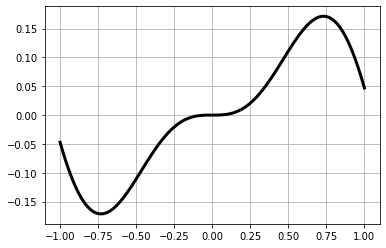

In [93]:
plt.plot(x,func(x),color='k',lw=3)
plt.grid(True)
plt.show()

## The Discriminator

### Define the discriminator model

In [47]:
def define_discriminator(n_inputs=2):
    model = Sequential()
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [48]:
# define the discriminator model
model_discriminator = define_discriminator()
# summarize the model
model_discriminator.summary()
# plot the model
#plot_model(model_discriminator, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 100)               300       
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 101       
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


### Generate real samples

In [49]:
def generate_real_samples(n,l=-1,h=1):
  # generate inputs in [-l, h]
  X1 = l+(h-l)*np.random.random(size=n)
	# generate outputs X^2
  X2 =func(X1)
	# stack arrays
  X1 = X1.reshape(n, 1)
  X2 = X2.reshape(n, 1)
  X = np.hstack((X1, X2))
  # generate class labels
  y = np.ones((n, 1))
  return X, y

In [50]:
generate_real_samples(5)

(array([[-0.351729  , -0.05067992],
        [-0.53748979, -0.12610645],
        [-0.67981112, -0.16746267],
        [-0.28882914, -0.0305136 ],
        [ 0.98975672,  0.05637502]]), array([[1.],
        [1.],
        [1.],
        [1.],
        [1.]]))

### Generate fake samples

In [51]:
def generate_fake_samples(n,l=-1,h=1):
  # generate inputs in [-l, h]
  X1 = l+(h-l)*np.random.random(size=n)
	# generate outputs X^2
  X2 = l+(h-l)*np.random.random(size=n)
	# stack arrays
  X1 = X1.reshape(n, 1)
  X2 = X2.reshape(n, 1)
  X = np.hstack((X1, X2))
  # generate class labels
  y = np.zeros((n, 1))
  return X, y

In [52]:
generate_fake_samples(5)

(array([[ 0.76073378, -0.7251373 ],
        [ 0.8027109 , -0.02068532],
        [-0.22343495, -0.5694514 ],
        [-0.20253836,  0.44344168],
        [-0.40488459,  0.90334664]]), array([[0.],
        [0.],
        [0.],
        [0.],
        [0.]]))

### Function to train the discriminator

In [53]:
def train_discriminator(model, n_epochs=1000, n_batch=128):
    half_batch = int(n_batch / 2)
    # run epochs manually
    for i in range(n_epochs):
        # generate real examples
        X_real, y_real = generate_real_samples(half_batch)
        # update model
        model.train_on_batch(X_real, y_real)
        # generate fake examples
        X_fake, y_fake = generate_fake_samples(half_batch)
        # update model
        model.train_on_batch(X_fake, y_fake)
        # evaluate the model
        _, acc_real = model.evaluate(X_real, y_real, verbose=0)
        _, acc_fake = model.evaluate(X_fake, y_fake, verbose=0)
        print(i, acc_real, acc_fake)

In [54]:
train_discriminator(model_discriminator,n_epochs=20)

0 0.015625 1.0
1 0.0625 1.0
2 0.015625 1.0
3 0.015625 0.984375
4 0.015625 1.0
5 0.046875 1.0
6 0.046875 1.0
7 0.0625 0.96875
8 0.125 1.0
9 0.046875 1.0
10 0.078125 1.0
11 0.109375 1.0
12 0.09375 0.984375
13 0.03125 1.0
14 0.140625 1.0
15 0.140625 1.0
16 0.15625 0.984375
17 0.109375 1.0
18 0.109375 1.0
19 0.140625 1.0


In [55]:
x_t,y_t=generate_fake_samples(5)
model_discriminator.evaluate(x_t,y_t)

5/5 [==============================] - 0s 199us/step


[0.43262189626693726, 1.0]

## The Generator

Training the discriminator model is straightforward. The goal is to train a generator model, not a discriminator model, and that is where the complexity of GANs truly lies.


### Defining the Generator model

The generator model **takes as input a point from the latent space and generates a new sample**, e.g. a vector with both the input and output elements of our function.

A **latent variable** is a hidden or unobserved variable, and a latent space is a multi-dimensional vector space of these variables. We can **freely choose** the **size of the latent space** for our problem and the **shape or distribution of variables** in the latent space.

This is because the latent space has no meaning until the generator model starts assigning meaning to points in the space as it learns. After training, points in the latent space will correspond to points in the output space, e.g. in the space of generated samples.

We will define a small latent space of a few dimensions and use the standard approach in the GAN literature of using a **Gaussian distribution** for each variable in the latent space. We will generate new inputs by **drawing random numbers from a standard Gaussian distribution, i.e. mean of zero and a standard deviation of one**.

The size of the latent dimension is parameterized in case we want to play with it later, and the output shape of the model is also parameterized, matching the function for defining the discriminator model

The output layer of the generator model will have two nodes for the two elements in a generated vector and will use a **linear activation** function.

Also, the generator model is **not fitted** directly, and therefore it **does not need to be compiled**.

In [76]:
# define the standalone generator model
def define_generator(latent_dim, n_outputs=2):
    model = Sequential()
    model.add(Dense(50, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(Dense(n_outputs, activation='linear'))
    return model

In [77]:
# define the discriminator model
model_gen = define_generator(5)
# summarize the model
model_gen.summary()
# plot the model (does not work on my windows laptop, needs proper installation of pydot and graphviz)
# plot_model(model_gen, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (None, 50)                300       
_________________________________________________________________
dense_48 (Dense)             (None, 2)                 102       
Total params: 402
Trainable params: 402
Non-trainable params: 0
_________________________________________________________________


### Testing the Generator model
This model cannot do much at the moment. Nevertheless, we can demonstrate how to use it to generate samples.

The first step is to generate new points in the latent space. We can achieve this by calling the `randn()` NumPy function for generating arrays of random numbers drawn from a standard Gaussian.

The array of random numbers can then be reshaped into samples: that is `n_rows` with five elements per row. The `generate_latent_points()` function below implements this and generates the desired number of points in the latent space that can be used as input to the generator model.

Next, we can use the generated points as input the generator model to generate new samples.

Note we update the `generate_fake_samples()` function in this section.

In [78]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n,l=-1,h=1):
    # generate points in the latent space
    x_input = l+(h-l)*np.random.random(size=latent_dim*n)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n, latent_dim)
    return x_input

In [79]:
def generate_fake_samples(generator, latent_dim, n):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n)
    # predict outputs
    X = generator.predict(x_input)
    # plot the results
    plt.scatter(X[:, 0], X[:, 1],color='k',s=15)
    plt.show()

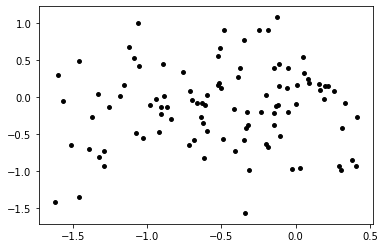

In [80]:
# size of the latent space
latent_dim = 5
# define the discriminator model
model_gen = define_generator(latent_dim)
# generate and plot generated samples
generate_fake_samples(model_gen, latent_dim, 100)

### Training the Generator model

***The weights in the generator model are updated based on the performance of the discriminator model***.

When the discriminator is good at detecting fake samples, the generator is updated more, and when the discriminator model is relatively poor or confused when detecting fake samples, the generator model is updated less.

This defines the **zero-sum or adversarial relationship** between these two models.

There may be many ways to implement this using the Keras API, but perhaps the simplest approach is to create a new model that subsumes or encapsulates the generator and discriminator models.

Specifically, a **new GAN model can be defined that stacks the generator and discriminator** such that the generator receives as input random points in the latent space, generates samples that are fed into the discriminator model directly, classified, and the output of this larger model can be used to update the model weights of the generator.

To be clear, we are not talking about a new third model, just a **logical third model that uses the already-defined layers and weights** from the standalone generator and discriminator models.

Only the discriminator is concerned with distinguishing between real and fake examples; therefore, the discriminator model can be trained in a standalone manner on examples of each.

The generator model is only concerned with the discriminator’s performance on fake examples. Therefore, we will mark **all of the layers in the discriminator as not trainable when it is part of the GAN model** so that they can not be updated and overtrained on fake examples.

When training the generator via this subsumed GAN model, we want the discriminator to think that the samples output by the generator are real. Therefore, **when the generator is trained as part of the GAN model, we will mark the generated samples as real (class 1)**.

The discriminator will then classify the generated samples as not real (class 0) or a low probability of being real. The backpropagation process used to update the model weights will see this as a large error and will update the model weights (i.e. only the weights in the generator) to correct for this error, in turn making the generator better at generating plausible fake samples.

So,
- Inputs: Point in latent space, e.g. a five-element vector of Gaussian random numbers.
- Outputs: Binary classification, likelihood the sample is real (or fake).


In [81]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels
    y = np.zeros((n, 1))
    return X, y

In [82]:
# define the combined generator and discriminator model, for updating the generator
def full_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [83]:
# size of the latent space
latent_dim = 5
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
model_gan = full_gan(generator, discriminator)
# summarize gan model
model_gan.summary()
# plot gan model (does not work on my windows laptop, needs proper installation of pydot and graphviz)
#plot_model(model_gan, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_35 (Sequential)   (None, 2)                 402       
_________________________________________________________________
sequential_34 (Sequential)   (None, 1)                 401       
Total params: 803
Trainable params: 402
Non-trainable params: 401
_________________________________________________________________


## Evaluating performance

### Define a function for summarizing performance by comparative plots

In [84]:
def summarize_performance(epoch, generator, discriminator, latent_dim, n=500):
    # prepare real samples
    x_real, y_real = generate_real_samples(n)
    # evaluate discriminator on real examples
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    # evaluate discriminator on fake examples
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print ("Data comparison after {} epochs".format(epoch+1))
    print()
    print("Accuracy for the real data: {}, Accuracy for the fake data: {}".format(acc_real, acc_fake))
    print()
    plt.scatter(x_real[:, 0], x_real[:, 1], color='red')
    plt.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
    plt.show()
    print()

### Add the `summarize_performance` function to the train function

In [85]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=256, n_eval=1000):
    # determine half the size of one batch, for updating the discriminator
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # prepare real samples
        x_real, y_real = generate_real_samples(half_batch)
        # prepare fake examples
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator
        d_model.train_on_batch(x_real, y_real)
        d_model.train_on_batch(x_fake, y_fake)
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = np.ones((n_batch, 1))
        # update the generator via the discriminator's error
        gan_model.train_on_batch(x_gan, y_gan)
        # evaluate the model every n_eval epochs
        if (i+1) % n_eval == 0:
            summarize_performance(i, g_model, d_model, latent_dim)

### Define models

In [86]:
# size of the latent space
latent_dim = 5
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
model_gan = full_gan(generator, discriminator)

### Showing performance of the `generator` before full training

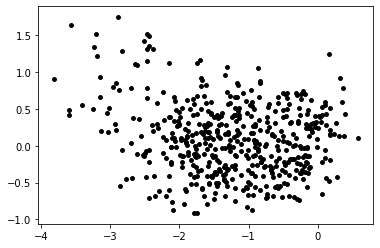

In [87]:
n=500
x,_=generate_fake_samples(generator, latent_dim, n)
plt.scatter(x[:,0],x[:,1],color='k',s=15)
plt.show()

### Now actual training of the GAN model
Function generated data in red and GAN generated data in blue.

See how, at first, the randomly generated points do not look anything closer to the underlying data, and then, as the iterations go on, they 'learn' the underlying statistical distribution and starts to mimic the functional form of the original data.

Data comparison after 1000 epochs

Accuracy for the real data: 0.48800000047683717, Accuracy for the fake data: 0.8560000004768371



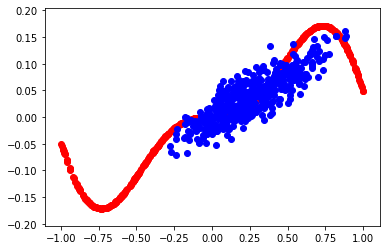


Data comparison after 2000 epochs

Accuracy for the real data: 0.47200000047683716, Accuracy for the fake data: 0.812



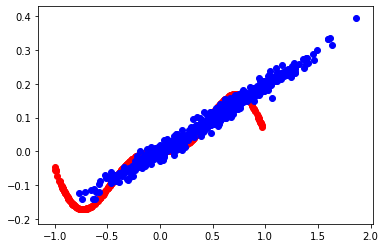


Data comparison after 3000 epochs

Accuracy for the real data: 0.6499999990463257, Accuracy for the fake data: 0.48199999952316286



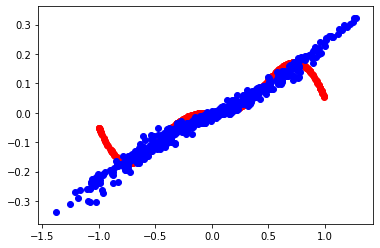


Data comparison after 4000 epochs

Accuracy for the real data: 0.48199999952316286, Accuracy for the fake data: 0.6240000004768371



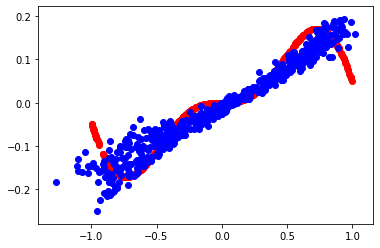


Data comparison after 5000 epochs

Accuracy for the real data: 0.22600000005960463, Accuracy for the fake data: 0.8139999995231628



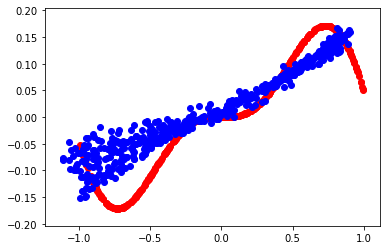


Data comparison after 6000 epochs

Accuracy for the real data: 0.0, Accuracy for the fake data: 1.0



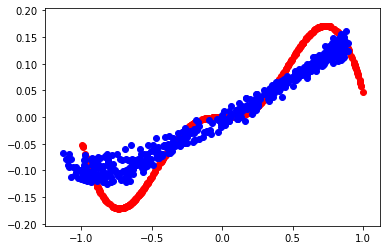


Data comparison after 7000 epochs

Accuracy for the real data: 0.5280000009536743, Accuracy for the fake data: 0.6240000004768371



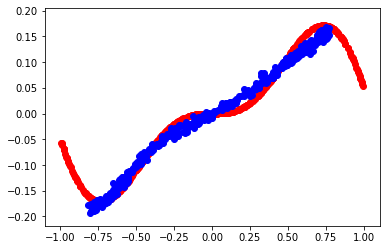


Data comparison after 8000 epochs

Accuracy for the real data: 0.7199999990463257, Accuracy for the fake data: 0.3520000002384186



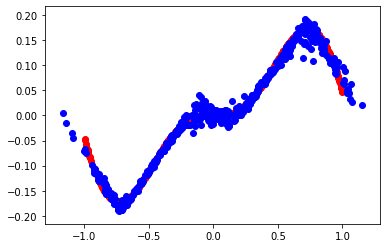


Data comparison after 9000 epochs

Accuracy for the real data: 0.6100000009536743, Accuracy for the fake data: 0.48800000023841855



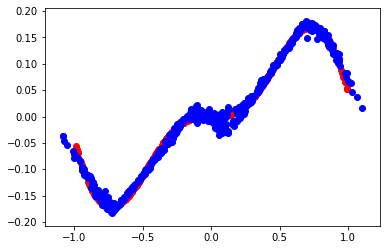


Data comparison after 10000 epochs

Accuracy for the real data: 0.49399999976158143, Accuracy for the fake data: 0.5439999995231628



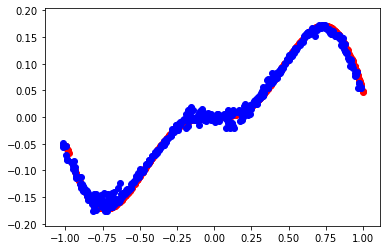

In [88]:
# train model
train(generator, discriminator, model_gan, latent_dim)

## Generate synthetic data now
Now, we can use the same old `generate_fake_samples()` function to generate as many synthetic data as needed. After training, now this function does not generate random data but a dataset closely following the algebraic function :-)

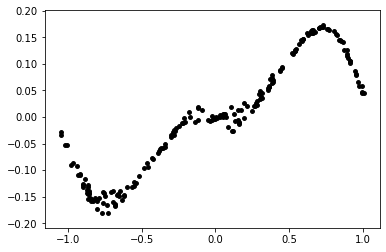

In [89]:
latent_dim=5
n=200
x,_=generate_fake_samples(generator, latent_dim, n)
plt.scatter(x[:,0],x[:,1],color='k',s=15)
plt.show()